## ARIMA Models

ARIMA stands for Autoregressive Integrated Moving Average. Compared with the above model it uses a linear combination of past time steps, and moving averages to predict t.


## Contents 
1. ARIMA parameters analysis
2. ARIMA multi-step taining and evaluation


#### ARIMA Models Evaluated
1. Multi-setp output ARIMA






ARIMA takes only a stationary time series. As explored in the ***DATA ANALYSIS*** notebook the load data can be made stationary by ***ANALYSIS RESULTS***



We will use the ARIMA model from statsmodels.api which takes the following arguments:
- p: is the number of lag observations in the model and can be estimated from Autocorrelation plots
- d: the number of times raw observations are differenced in order to make the series stationary. This is determined with a Dicky-Fuller test.
- q: the side of the moving average window. The order of moving average.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
sns.set_style('dark')

#import libraries for statistical analysis
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#import libraries for parallel processing
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

#import custom utils including persistence testbench
from model_persistence import get_persistence_dataset, train_test_split, walk_forward_evaluation, calculate_errors, plot_error

In [2]:
#load the dataset and crete the train and test sets.
data = get_persistence_dataset()

#split using default date 2017-12-31
train, test = train_test_split(data)
train.head(3)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0
2015-01-03,25564.0,23584.0,22194.0,21296.0,21145.0,21316.0,21674.0,22127.0,22756.0,24654.0,...,26416.0,25362.0,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0


### ARIMA Parameter Analysis


We will use the ARIMA model from statsmodels.api. The ARIMA takes three arguments p, d, q and represent the model's lags, differncing, and moving window size. Arriving at their inital values is done via the box-jenkins method described below:
- p: The number of lag observations in the model and can be estimated from an Autocorrelation plot as the number of lag points that show deviation outside the confidence band.
- d: The number of times raw observations are differenced in order to make the series stationary. This is determined with a Dicky-Fuller test.
- q: The side of the moving average window. The order of moving average.

##### Startionay and differncing of the dataset

As described in the stationary test in the Data Analysis workbook, set of daily mean data was stationary. Here we test if the hourly data is stationary using the adfuller test over a period of 1 week of lags (24 * 7).

***Null Hypothesis***: The dataset is non-stationary and therefore differencing must be carried out.

If p-value is < 0.05 (two tailed test), we reject the null and assume that the time series is stationary.

In [3]:
#flatten the train set because the statistical model only accepts univariate series
train_flat = train.values.flatten()

adful_t = sm.tsa.adfuller(train_flat, maxlag=24*7)
print(pd.Series(adful_t[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -7.804579e+00
p-value           7.339533e-12
#Lags             1.680000e+02
Observations      2.613500e+04
dtype: float64


The p-value of the test is significantly smaller than the threshold of 0.05 and therefore we ***reject the null*** and assume a stationary dataset.

Therefore the default model paramter for d (the differncing value) is 0. We will also invesitgate a differencing paramter of 24 and 168 corresponding with the previous day, and the previous week.



##### Autocorrelation and partial autocorrelation

Descrption of the plots:

ACF - Describes the direct and indirect relationships between laging (shifted) autoregressive features. I.e. the relationships between t, t-1, t-2, t-3 etc. taking into account the interrelatinships between features, in this case t-1 and t-2, t-2 and t-3 etc.

PACF - Describes only the direct relationships between lagging (shifted) and autoregressive features.

p (AR): Determining the autoregressive hyperparameter value p, is best described as the number of lags beyond which there is no significant relationship. This is seen in the ACF as the point at which plot values lie outside the significance band (light blue horizontal band)

q (MR): Determining the moving average hyperparameter value q, is described as the direct relationship with the lag feature and the feature. 

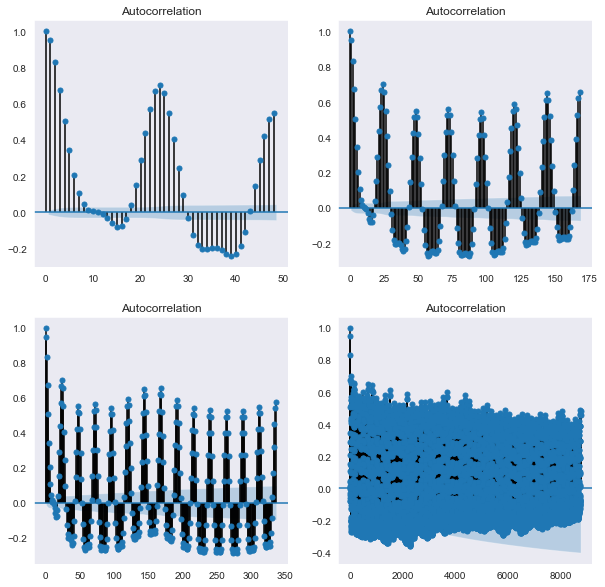

In [65]:
#plot the ACF 
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [48, 24*7, 24*14, 24*365]

for lag, ax in zip(lags, axs.flatten()):
    plot_acf(train_flat, lags=lag, ax=ax)
plt.show()

The autocorrelation plot shows significant positive corelations in the first 9 lags. However in this problem we are attempting to forecast the next 24 hours and using a lag less than 24 does not capture the full context of a short-term day ahead forecast.

The cyclic pattern of the autoregressive features is apprent in the plots. In the ARIMA model the assumption is that beyond the chosen lag point (p), there is no correlation. Observing the bottom right plot we see this point occurs around approximately 4000 lags (approximately 1/2 year).

For the scope of this project calculating with 4000 lags is not feasible. We will focus on lag points 24 (previous day), 48 (previous two days), 168 (previous week).

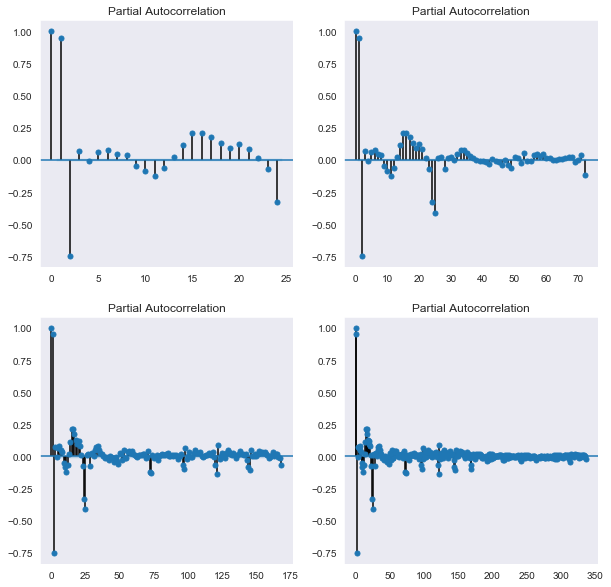

In [68]:
#plot the ACF 
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [24, 24*3, 24*7, 24*14]

for lag, ax in zip(lags, axs.flatten()):
    plot_pacf(train_flat, lags=lag, ax=ax)
plt.show()

The partial autocorrelation plot shows that beyond 24 lags there is no signficant partial autocorrelation. Considering this we will investigate lags 2, 3, 12, and 24 for the moving average values.

##### Summary of hyperparmeter values to investigate

- p (autoregressive): 24, 48, 168
- d (differncing): 0, 24, 168
- q (moving average): 0, 2, 3, 12, 24

### ARIMA Model: Baseline

Baseline parametres are chosen as (p, d, q) = (24, 0, 0)

In [76]:
#run the model for one forecasting period and estimate how long it will take to implement

def test_run_ARIMA(train_flat):
    #setup a model instence
    model_24 = ARIMA(train_flat, order=(24, 0, 0))

    #fit the model
    model_fit_24 = model_24.fit()

    #run the 24 interval forecast and return the operation time
    forecast_24, std_24, intervals_24 = model_fit_24.forecast(24)
    
    return forecast_24, std_24, intervals_24
    
%time forecast_24, std_24, intervals_24 = test_run_ARIMA()    

CPU times: user 1.5 s, sys: 91.1 ms, total: 1.6 s
Wall time: 594 ms


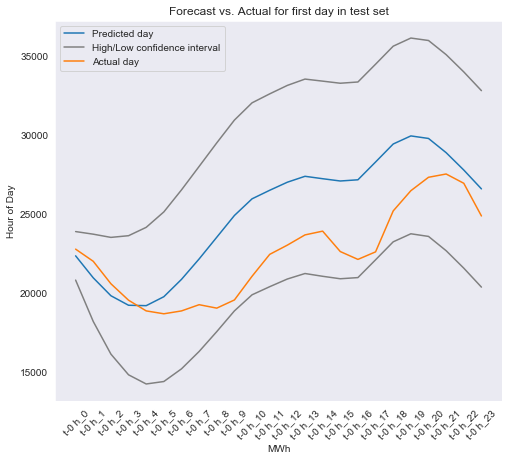

In [105]:
#plot the result and get an idea if the forecast is in the right direction
fig = plt.figure(figsize=(8,7))

print()


plt.plot(forecast_24, label='Predicted day')
plt.plot(intervals_24[:,0], label='High/Low confidence interval', color='gray')
plt.plot(intervals_24[:,1], color='gray')
plt.plot(test.iloc[0,:], label='Actual day')
plt.xticks(rotation=45)
plt.title('Forecast vs. Actual for first day in test set')
plt.xlabel('MWh')
plt.ylabel('Hour of Day')
plt.legend()
plt.show()

##### ARIMA model function

We will run this function on the paramters (1,0,0) acorss the whole data set as a baseline.

In [4]:
#define a model to insert into the training rig created in the persistence workbook
def arima_model(history, config):
    
    #convert dataframe to numpy array and flatten into column vector
    history_flat = history.values.flatten()
    
    p,d,q = config
    
    #initalize the ARIMA model
    model = ARIMA(history_flat, order=(p, d, q))
    
    #fit model
    model_fit = model.fit()
    
    #generate forecast for the next 24 hours
    forecast, _, _ = model_fit.forecast(24)
    
    #save the model
    #name = 'model-' + str(datetime.datetime.now()) +'.pkl'
    #model_fit.save(name)
    
    #print('Done. Model Saved.')
    
    return forecast

In [104]:
errors, errors_mean, prediction = walk_forward_evaluation(arima_model, train, test, 'arima_model', config=(1,0,0))

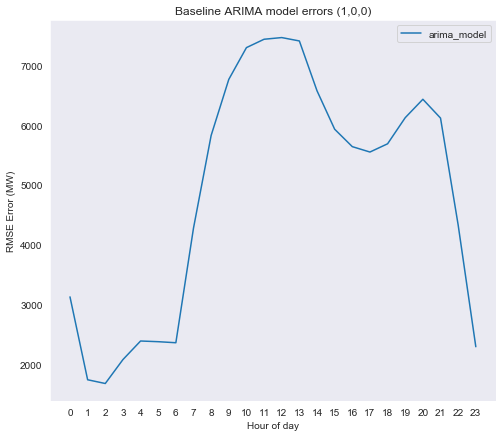

In [106]:
plot_error(errors, result_set=['arima_model'], title='Baseline ARIMA model errors (1,0,0)')

##### GridSearch framework for testing

Grid searching over the identified hyperparameter space will allow us to see which configuration delivers the best forecasts.

The grid search code below is adapted from Jason Brownlee's impelmentation in his Book: Deep Learning Time Series Forecasting.

In [5]:
def score_model(model, data, split_date, cfg):
    """
    Function that
    - splits the data into test and train
    - tries to initalize an intence of the model
    - prints and returns the model errors, mean rmse, and predictions
    
    """
    
    result = None
    errors = None
    predictions = None
    
    #get the name of the model
    name = str(model)
    #get the model parameters
    key = str(cfg)

    #initalize the train and test data
    train, test = train_test_split(data, split_date=split_date)
    
    try:
        with catch_warnings():
            filterwarnings('ignore')
            
            #run walk forward and return rmse, errors, and forecast
            errors, result, predictions = walk_forward_evaluation(model, train, test, name, config=cfg)
    except:
        print('Bad config' + str(cfg))
    
    if result is not None:
        print(' Model {}: {}'.format(key, result))
    
    return (key, result, errors, predictions)

In [6]:
def grid_search(model, data, cfg_list, split_date, parallel=True):
    """
    Grid search function
    - launches parallel jobs according to number of cpus available
    - one job per model configuration 
    """

    
    scores = []

    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        #set tasks into the buffer
        tasks = (delayed(score_model)(model, data, split_date, cfg) for cfg in cfg_list)
        #execute tasks in order
        scores = executor(tasks)
    else:
        for cfg in cfg_list:
            score = score_model(model, data, split_date, cfg)

        scores.append(score)
    
    #remove the scores with no values
    scores = [r for r in scores if r[1] != None]
    
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    
    #scores contains the configuration, error_rmse, errors, predictions
    return scores

In [7]:
# function to create the model configurations to search over.
def arima_configs(lags, diffs, mas):
    configs = list()
    for lag in lags:
        for diff in diffs:
            for ma in mas:
                cfg = [lag, diff, ma]
                configs.append(cfg)
    return configs

##### Testing the grid search function

Before setting up a large job with the whole training set and 

In [10]:
data = get_persistence_dataset(start='2018-01-01', stop='2018-03-31')

model = arima_model

lags = [1,2]
diffs = [0,1,2]
mas = [0,1,2]

cfg_list = arima_configs(lags, diffs, mas)
split_date = '2018-03-01'
%time scores = grid_search(model, data, cfg_list, split_date, parallel=True)

print('done')

Bad config[1, 2, 1]
Bad config[1, 2, 2]
Bad config[1, 2, 0]
Bad config[1, 0, 0]
Bad config[1, 1, 0]
Bad config[2, 1, 0]
Bad config[2, 1, 1]
Bad config[1, 0, 1]
Bad config[2, 1, 2]
Bad config[2, 2, 1]
Bad config[2, 2, 0]
Bad config[1, 0, 2]
Bad config[1, 1, 1]
Bad config[2, 0, 1]
Bad config[2, 0, 0]
Bad config[2, 0, 2]
Bad config[1, 1, 2]
Bad config[2, 2, 2]
CPU times: user 234 ms, sys: 142 ms, total: 375 ms
Wall time: 2min 38s
done


##### Collect scores and save to a csv

Before launching the job in the cloud want to be able to save and revisit the results.

In [71]:
data = get_persistence_dataset(start='2018-01-01', stop='2018-03-31')

model = arima_model

lags = [1,2]
diffs = [1,2]
mas = [1,2]

cfg_list = arima_configs(lags, diffs, mas)
split_date = '2018-03-01'
%time scores = grid_search(model, data, cfg_list, split_date, parallel=True)

print('done')



Bad config[1, 2, 1]
Bad config[1, 2, 2]
Bad config[2, 1, 1]
Bad config[2, 1, 2]
Bad config[2, 2, 1]
 Model [1, 1, 1]: [[1664.271544480803]]
 Model [1, 1, 2]: [[1955.0000429901872]]
 Model [2, 2, 2]: [[1664.8229369852024]]
CPU times: user 216 ms, sys: 88.1 ms, total: 304 ms
Wall time: 2min 26s
done


In [66]:
scores[0]

('[1, 1, 1]', [[1664.271544480803]],     <function arima_model at 0x1c1bb8f158>
 0                              1664.271544
 1                              1632.294191
 2                              1775.129387
 3                              1836.036186
 4                              1831.323466
 5                              1721.970192
 6                              2764.702270
 7                              5388.723615
 8                              7501.328477
 9                              8993.529583
 10                             9773.685183
 11                            10028.085311
 12                             9933.906391
 13                             9823.093769
 14                             8991.805985
 15                             8211.821879
 16                             7801.536809
 17                             7628.138044
 18                             7581.421789
 19                             8560.691071
 20                             9747.844

###### Time estimation of model computation

In [16]:
#### grid search parameters

lags = [24, 48, 168]
diffs = [0, 24, 168]
mas = [0, 2, 3, 12, 24]

len(grid_search(lags, diffs, mas))

45

In [23]:
%time grid_search(lags, diffs, mas)

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 21 µs


[[24, 0, 0],
 [24, 0, 2],
 [24, 0, 3],
 [24, 0, 12],
 [24, 0, 24],
 [24, 24, 0],
 [24, 24, 2],
 [24, 24, 3],
 [24, 24, 12],
 [24, 24, 24],
 [24, 168, 0],
 [24, 168, 2],
 [24, 168, 3],
 [24, 168, 12],
 [24, 168, 24],
 [48, 0, 0],
 [48, 0, 2],
 [48, 0, 3],
 [48, 0, 12],
 [48, 0, 24],
 [48, 24, 0],
 [48, 24, 2],
 [48, 24, 3],
 [48, 24, 12],
 [48, 24, 24],
 [48, 168, 0],
 [48, 168, 2],
 [48, 168, 3],
 [48, 168, 12],
 [48, 168, 24],
 [168, 0, 0],
 [168, 0, 2],
 [168, 0, 3],
 [168, 0, 12],
 [168, 0, 24],
 [168, 24, 0],
 [168, 24, 2],
 [168, 24, 3],
 [168, 24, 12],
 [168, 24, 24],
 [168, 168, 0],
 [168, 168, 2],
 [168, 168, 3],
 [168, 168, 12],
 [168, 168, 24]]